# A brief introduction to `simpleQE`

simpleQE is not currently tuned for large-scale data analysis, and is meant for research-level, exploratory analysis.

Nick Kern
<br>
11/1/2020

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, signal
import copy

import simpleqe as sqe
import palettable as pt  # pip install this

## Setup Your Covariance Matrices

These will be used in our GPR analysis, but also to generate mock data.

In [2]:
def Cfg(freqs, variance=1e3, length_scale=5e6):
    """
    A Gaussian foreground covariance
    
    freqs : array_like, (Nfreqs, 1)
        frequency array in Hz
    variance : float
        Amplitude of diagonal
    length_scale : float
        length scale parameter (Hz)
    """
    return variance * np.exp(-0.5 * (freqs - freqs.T)**2 / length_scale**2)

def Cn(freqs, variance=1):
    """
    A white noise covariance
    
    freqs : array_like, (Nfreqs, 1)
        frequency array in Hz
    variance : float
        Amplitude of diagonal
    """
    return variance * np.eye(len(freqs))

def Ceor(freqs, variance=1e-1, length_scale=1e6):
    """
    An exponential EoR covariance
    
    freqs : array_like, (Nfreqs, 1)
        frequency array in Hz
    variance : float
        Amplitude of diagonal
    length_scale : float
        length scale parameter (Hz)
    """
    return variance * np.exp(-np.abs(freqs - freqs.T) / length_scale)

## Generate Data

Generate mock data. This is a simple simulation of independent realizations of a single baseline.

In [3]:
freqs = np.linspace(130e6, 140e6, 50, endpoint=True)  # Hz
Nfreqs = len(freqs)
cosmo = sqe.utils.Cosmology()

In [4]:
# simulate fg, eor, noise and stick into container D
# note that D.x1 and D.x2 are the two data realizations, which have the same FG and EoR realizations
# (you can check by comparing F.x1 and F.x2), but have different noise realizations (therefore no noise bias)
Ntimes = 100
D, F, E, N = sqe.utils.gen_data(freqs, Cfg, Ceor, Cn, Ntimes=Ntimes, cosmo=cosmo, ind_noise=True, Omega_Eff=0.1)

Text(0.5, 1, 'Visibility components [arbitrary units]')

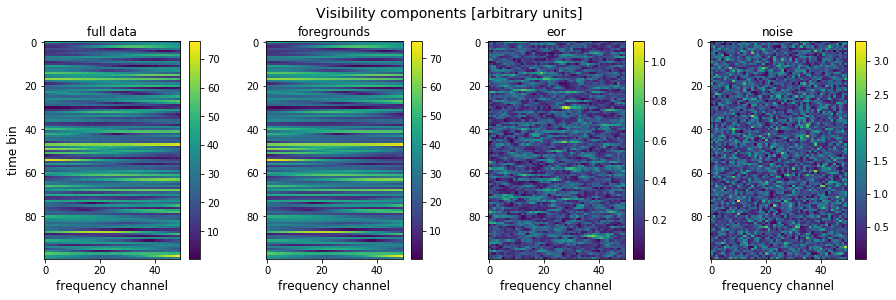

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
fig.subplots_adjust(wspace=.3)

labels = ['full data', 'foregrounds', 'eor', 'noise']
for i, q in enumerate([D, F, E, N]):
    ax = axes[i]
    cax = ax.imshow(np.abs(q.x1), aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(labels[i], fontsize=12)
    ax.set_xlabel('frequency channel', fontsize=12)
    if i == 0:
        ax.set_ylabel('time bin', fontsize=12)
fig.suptitle("Visibility components [arbitrary units]", fontsize=14, y=1)

__Figure 1__ | Components of the data in the visibility, simulated in arbitrary units with each time bin being uncorrelated from the next.

## Perform GPR-FS

In [6]:
def errorbar(ax, kp, y, yerr=None, W=None, fmt='o', ks=np.s_[:], **kwargs):
    if W is not None:
        # get x bins and errorbars from window functions
        x, xerr_low, xerr_hi = sqe.utils.interp_Wcdf(W, kp)
        xerr = np.array([[xerr_low], [xerr_hi]]).T
    else:
        x = kp
        xerr = np.zeros((len(kp), 1, 2))
    if yerr is None:
        yerr = np.array([None] * len(y))
    
    # iterate over points and plot
    p = []
    for xp, yp, ye, xe in zip(x[ks], y[ks], yerr[ks], xerr[ks]):
        p.append(ax.errorbar(xp, yp, ls='', xerr=xe.T, yerr=ye, fmt=fmt, **kwargs))

    return p

In [7]:
# generate weighting matrices
I = np.eye(Nfreqs)
t = np.diag(signal.windows.blackmanharris(Nfreqs))  # tapering function
gpr_fs = I - F.C @ np.linalg.pinv(D.C)

In [8]:
# set R matrices
D.set_R(gpr_fs); F.set_R(t); E.set_R(I); N.set_R(I)

In [9]:
# compute Q and H
D.compute_Q(); F.compute_Q(); E.compute_Q(); N.compute_Q()
D.compute_H(); F.compute_H(); E.compute_H(); N.compute_H()

In [10]:
# compute un-normalized band power: q
D.compute_q(); F.compute_q(); E.compute_q(); N.compute_q()

In [11]:
# compute normalization, window func, V, and normalized p (and spherically average it)
D.compute_MWVp(norm='H^-1/2', C_data=D.C, C_bias=F.C)  # no noise bias (see above)
F.compute_MWVp(norm='I')
E.compute_MWVp(norm='I')
N.compute_MWVp(norm='I')

/Users/nkern/Software/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$W(k)$')

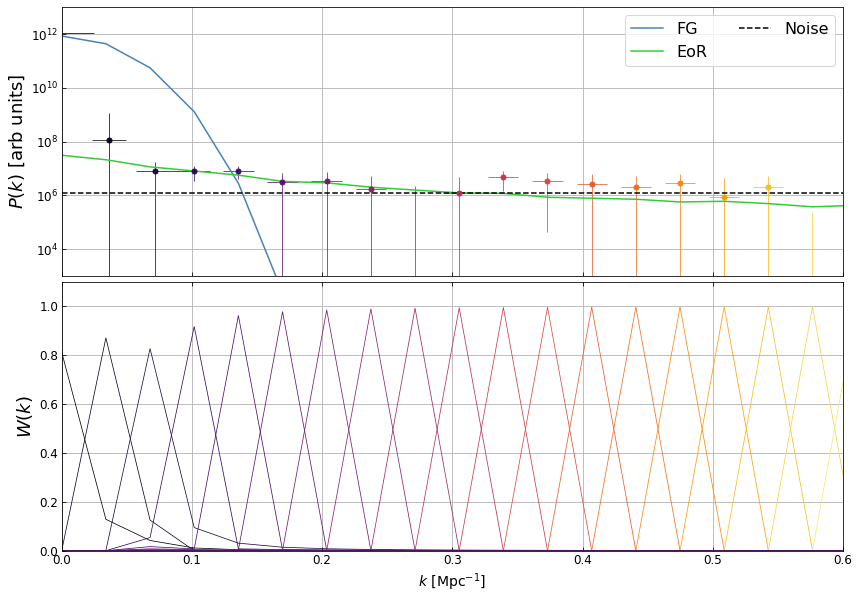

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.subplots_adjust(hspace=0.02)

xlim = 0.0, 0.6
ylim = 1e3, 1e13
prop_cycle = pt.matplotlib.Inferno_20.mpl_colors

ax = axes[0]
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
# plot FG averaged over time
p1, = ax.plot(F.kp_sph, np.abs(np.mean(F.p_sph, axis=1).real), c='steelblue', lw=1.5, alpha=1)
# plot eor averaged over time
p2, = ax.plot(E.kp_sph, np.abs(np.mean(E.p_sph, axis=1).real), c='limegreen', lw=1.5, alpha=1)
# plot noise averaged over time
p3 = ax.axhline(np.mean(np.abs(np.mean(N.p_sph, axis=1).real)), color='k', ls='--', lw=1.5)
# plot GPR-FS
ax.set_prop_cycle('color', prop_cycle)
errorbar(ax, D.kp_sph, np.mean(D.p_sph - D.b_sph, axis=1).real,
              yerr=np.sqrt(np.diag(D.V_sph)/Ntimes), fmt='o', ms=5, elinewidth=0.75, W=D.W_sph)

ax.grid()
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_ylabel(r'$P(k)$ [arb units]', fontsize=18)
ax.legend([p1, p2, p3], ['FG', 'EoR', 'Noise'], fontsize=16, ncol=2)

ax = axes[1]
ax.set_prop_cycle('color', prop_cycle)
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
ax.plot(D.kp_sph, D.W_sph.T, lw=0.75, alpha=1)
ax.grid()
ax.set_xlim(xlim)
ax.set_ylim(-.0, 1.10)
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$', fontsize=14)
ax.set_ylabel(r'$W(k)$', fontsize=18)

__Figure 2__ | Example power spectra of FG (blue), EoR (green), noise floor (black) and recovered power spectra after GPR-FS (points).

## Let's try wideband inpainting

In [13]:
# triple the bandwidth from before
freqs = np.linspace(120e6, 150e6, 150, endpoint=True)  # Hz
Nfreqs = len(freqs)
cosmo = sqe.utils.Cosmology()

In [14]:
# generate a wideband dataset, with a narrowband power spectrum window
Ntimes = 100
D, F, E, N = sqe.utils.gen_data(freqs, Cfg, Ceor, Cn, Ntimes=Ntimes, cosmo=cosmo, ind_noise=True, Omega_Eff=0.1,
                                pspec_spw=slice(50, 100))
D_flagged = copy.deepcopy(D)

In [15]:
# generate flags
flags = np.zeros(Nfreqs, np.bool)

fchans = [(20, 21), (40, 41), (80, 81), (95, 96), (120, 121)]
for fc in fchans:
    flags[fc[0]:fc[1]] = True

Text(0.5, 0, 'frequency channel')

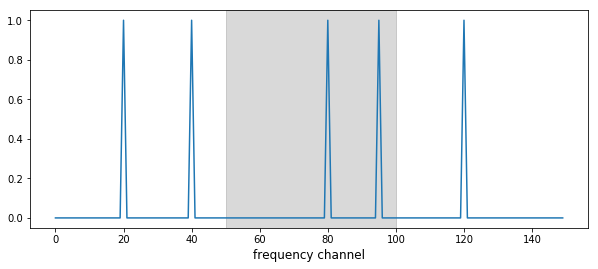

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.axvspan(50, 100, color='k', alpha=0.15)
ax.plot(flags)
ax.set_xlabel('frequency channel', fontsize=12)

__Figure 3__ | Flagging mask we will apply to the data. Shaded region indicates power spectrum spectral window.

In [17]:
# generate weighting matrices
I = np.eye(Nfreqs)
t = np.eye(Nfreqs)
t[50:100, 50:100] = np.diag(signal.windows.blackmanharris(D.spw_Nfreqs))  # tapering function
gpr_fs = I - F.C @ np.linalg.pinv(D.C)

Wf = I.copy()
Wf[~flags, ~flags] = 0.0

# get inpainting matrices across wide bandwidth
gpr_dm = (F.C) @ np.linalg.inv(F.C + N.C + E.C + Wf * 1e10)
gpr_ip = I - Wf + Wf @ gpr_dm

In [18]:
# set R matrices
D.set_R(t @ gpr_ip); D_flagged.set_R(t @ (I-Wf)); F.set_R(t); E.set_R(t); N.set_R(t)

# compute Q and H
D.compute_Q(); D_flagged.compute_Q(); F.compute_Q(); E.compute_Q(); N.compute_Q()
D.compute_H(); D_flagged.compute_H(); F.compute_H(); E.compute_H(); N.compute_H()

# compute un-normalized band power: q
D.compute_q(); D_flagged.compute_q(); F.compute_q(); E.compute_q(); N.compute_q()

# compute normalizations
D.compute_MWVp(norm='I', C_data=D.C)
D_flagged.compute_MWVp(norm='I')
F.compute_MWVp(norm='I')
E.compute_MWVp(norm='I')
N.compute_MWVp(norm='I')

Text(0, 0.5, '$W(k)$')

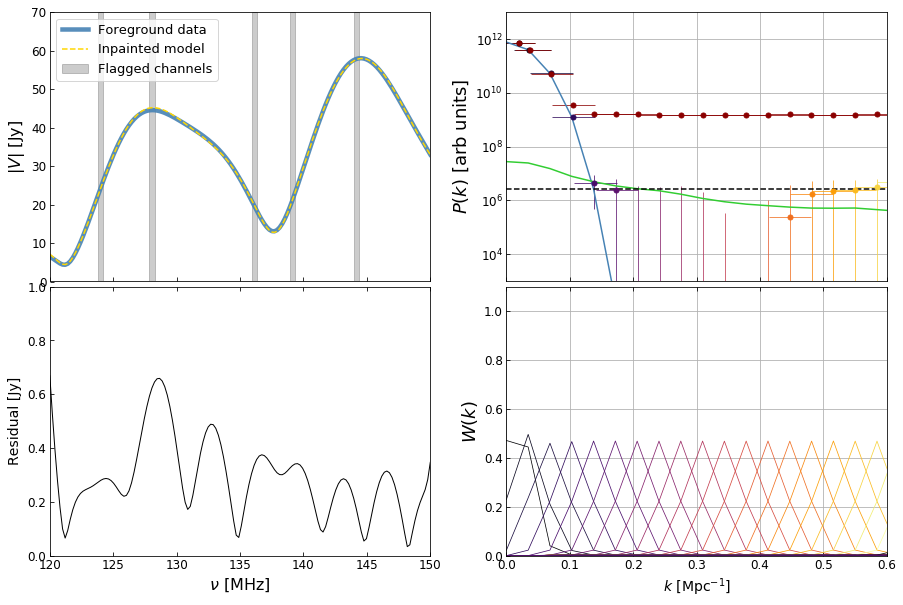

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.02)

xlim = 120, 150
ax = axes[0, 0]
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
ax.axvspan(50, 100, color='limegreen', alpha=0.15)
for fc in fchans:
    ax.axvspan(freqs[fc[0]-1]/1e6, freqs[fc[1]]/1e6, color='k', alpha=0.2)
d = D.x1[1].copy()
dip = gpr_dm @ d
d[flags] *= np.nan
p0, = ax.plot(F.freqs/1e6, np.abs(F.x1[1]), lw=4.5, color='steelblue', alpha=0.9)
p1, = ax.plot(F.freqs/1e6, np.abs(dip), lw=1.5, color='gold', ls='--')
r = plt.Rectangle((0,0), 0, 0, color='k', alpha=0.2)
ax.set_xlim(xlim)
ax.set_ylim(0.1, 70)
ax.legend([p0, p1, r], ['Foreground data', 'Inpainted model', 'Flagged channels'], fontsize=13)
ax.set_ylabel(r'$|V|$ [Jy]', fontsize=16)
ax.set_xticklabels([])

ax = axes[1, 0]
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
#ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0e'))
ax.plot(F.freqs/1e6, np.abs(dip - F.x1[1]), color='k', lw=1)
ax.set_xlim(xlim)
ax.set_ylim(0.0001, 1)
ax.set_xlabel(r'$\nu$ [MHz]', fontsize=16)
ax.set_ylabel(r'Residual [Jy]', fontsize=14, labelpad=5)


xlim = 0.0, 0.6
ylim = 1e3, 1e13
prop_cycle = pt.matplotlib.Inferno_20.mpl_colors

ax = axes[0, 1]
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
# plot FG averaged over time
p1, = ax.plot(F.kp_sph, np.abs(np.mean(F.p_sph, axis=1).real), c='steelblue', lw=1.5, alpha=1)
# plot eor averaged over time
p2, = ax.plot(E.kp_sph, np.abs(np.mean(E.p_sph, axis=1).real), c='limegreen', lw=1.5, alpha=1)
# plot noise averaged over time
p3 = ax.axhline(np.mean(np.abs(np.mean(N.p_sph, axis=1).real)), color='k', ls='--', lw=1.5)
# plot GPR-FS
ax.set_prop_cycle('color', prop_cycle)
errorbar(ax, D.kp_sph, np.mean(D.p_sph, axis=1).real,
         yerr=np.sqrt(np.diag(D.V_sph)/Ntimes), fmt='o', ms=5, elinewidth=0.75, W=D.W_sph)
errorbar(ax, D.kp_sph, np.mean(D_flagged.p_sph, axis=1).real, c='darkred',
         yerr=np.sqrt(np.diag(D_flagged.V_sph)/Ntimes), fmt='o', ms=5, elinewidth=0.75, W=D_flagged.W_sph)

ax.grid()
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_ylabel(r'$P(k)$ [arb units]', fontsize=18)
#ax.legend([p1, p2, p3, p4], ['FG', 'EoR', 'Noise', 'GPR-FS'], fontsize=16, ncol=2)

ax = axes[1, 1]
ax.set_prop_cycle('color', prop_cycle)
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
ax.plot(D.kp_sph, D.W_sph.T, lw=0.75, alpha=1)
ax.grid()
ax.set_xlim(xlim)
ax.set_ylim(-.0, 1.10)
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$', fontsize=14)
ax.set_ylabel(r'$W(k)$', fontsize=18)

__Figure 4__ | Foreground inpainting in frequency space (left) and the associated power spectra (right). Red points are the flagged but un-inpainted dataset. 